Found short period K16 planet for high blur (2d), when doing a not per-transit periodogram. For a per-transit periodogram, a couple of noise events can mask the many transits. Short periods need more blurring.

In [1]:
#can we find K16 while assuming basic values for the e and i parameters?
import copy
import numpy as np
import matplotlib.pyplot as p
import astropy.units as u
import funcs
import pickle

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
#Load lightcurve
lc_notran = np.genfromtxt('Lightcurves/K16_cln_noecl_notran.txt')
time_nt = lc_notran[:,0]
flux_nt = lc_notran[:,1]
err_nt = lc_notran[:,2]


In [4]:
# Kepler 16
cb = funcs.CBSystem(m1 = 0.6897,f1 = 1.,m2 = 0.20255,f2 = 0.01555,
                    ab = 0.22431,r1 = 0.6489 * u.Rsun.to('au'),r2 = 0.22623 * u.Rsun.to('au'),
                    eb = 0.15944,ib = np.deg2rad(90.3401),wb = np.deg2rad(263.464),
                    fb = np.deg2rad(186.53239),
                    mp = .03e-3,ap = 0.7048,rp = 0.7538 * u.Rjupiter.to('au'),ep = 0.0069,
                    ip = np.deg2rad(90.0322),wp = np.deg2rad(318.0),fp = np.deg2rad(148.92),
                    Wp = np.deg2rad(0.003),
                    t0 = 2455212.12316)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp0 = np.deg2rad(148.92)
print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
dt = 0.02
#t = np.arange(2454953,2456424,dt)
#t = np.arange(np.min(time),np.max(time),dt)
t = time_nt

41.0790034492
228.79461019691053


In [5]:
#lightcurve statistic - transfer lightcurve to a varying duration statistic. 
#0.1d, 0.15d, 0.2d, .25d, .3d, .35d, 0.4d, .45d, .5d (not all useful for K16, but generally speaking will be)

windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
minpoints = 3
blurscan = 0.3 #in days
#window lightcurve with duration - 
lcstat_nt = {}
blurlcstat_nt = {}
for win in windows:
    lcstat_nt[win], blurlcstat_nt[win] = funcs.running_mean_gaps(time_nt,flux_nt-1,win,minpoints,blurscan)
    
blurlcstat_nt_norm = funcs.normalise_stat(blurlcstat_nt,lcstat_nt,window=50)

<IPython.core.display.Javascript object>


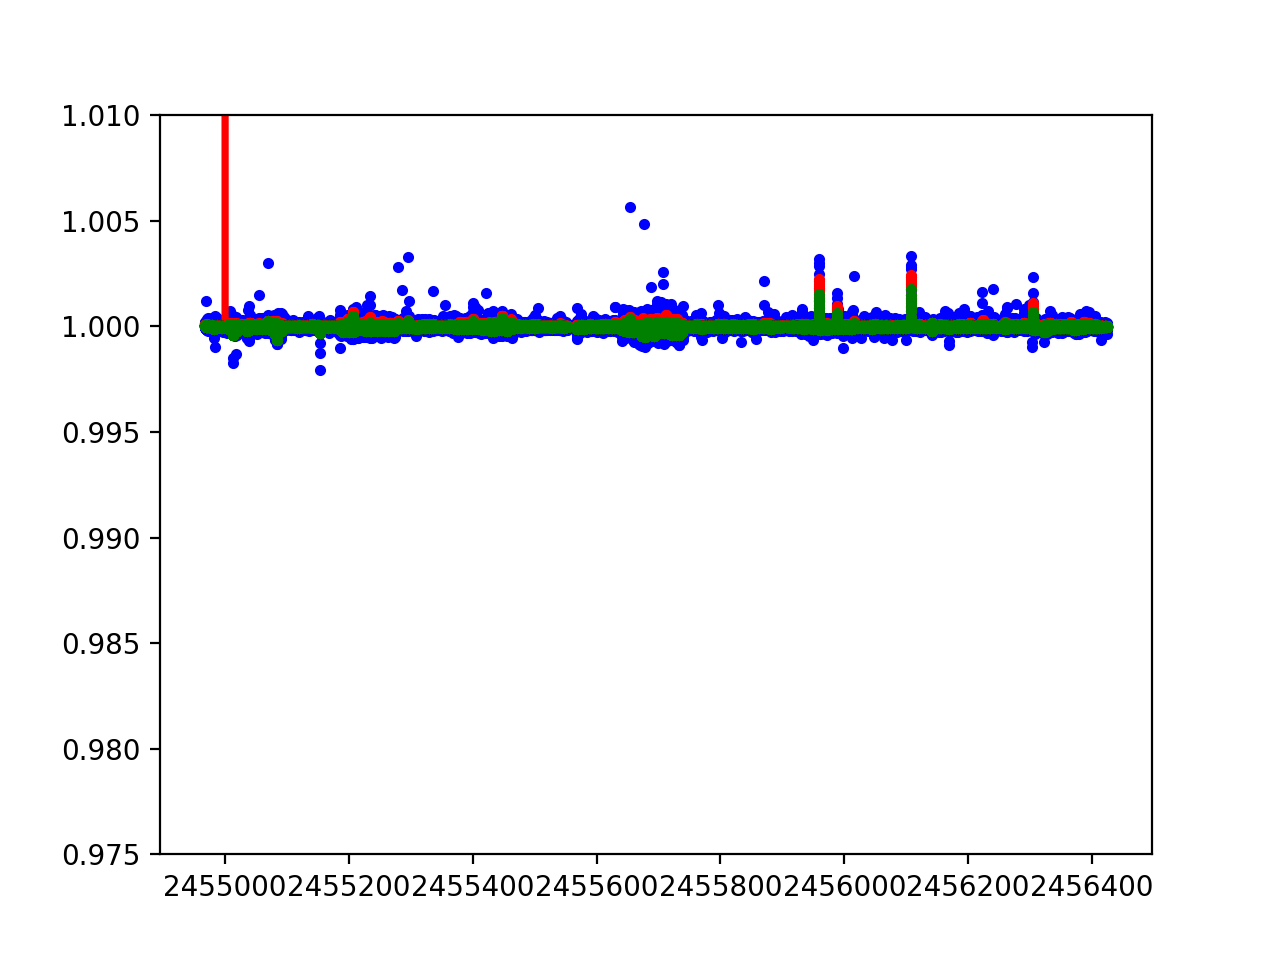

(0.975, 1.01)

In [6]:
p.figure()
p.plot(time_nt,flux_nt,'b.')
p.plot(time_nt,lcstat_nt[0.3]+1,'r.-')
p.plot(time_nt,blurlcstat_nt[0.3]+1,'g.-')
p.ylim(0.975,1.01)

In [9]:
#injected planet parameters
cb.mp = .003e-3
cb.ep = 0.01
cb.wp = np.deg2rad(150.0)
cb.ip = np.deg2rad(90.02)
cb.rp = 0.1 * u.Rjupiter.to('au')
cb.fp = np.deg2rad(270.)
cb.Wp = np.deg2rad(0.0)
p_p = 210.
cb.ap = ((p_p/365.25)**2 * (cb.m1+cb.m2))**(1./3.)

tts_inj,tds_inj = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)

tts_inj = tts_inj[tds_inj>0]
tds_inj = tds_inj[tds_inj>0]

In [10]:
print(tts_inj)
print(tds_inj)

[ 2455022.36596273  2455227.59220727  2455432.85741198  2455638.16060286
  2455843.49950722  2456048.87185241  2456254.27536573]
[ 0.43598178  0.42878799  0.42302353  0.41853946  0.41493468  0.41161502
  0.4077941 ]


In [11]:
#inject transits
tdepth = (cb.rp/cb.r1)**2 * (cb.f1/(cb.f1+cb.f2)) #dilution included. primary transits
flux_inj = flux_nt.copy()
for tt,td in zip(tts_inj,tds_inj):
    flux_inj = funcs.inject_u_transit(tt,td,time_nt,flux_inj,tdepth)

In [12]:
#outlier cut
cutidx = funcs.outlier_cut(time_nt,flux_inj,10, 250)
time_nt_cut, flux_inj_cut = time_nt[cutidx],flux_inj[cutidx]

<IPython.core.display.Javascript object>


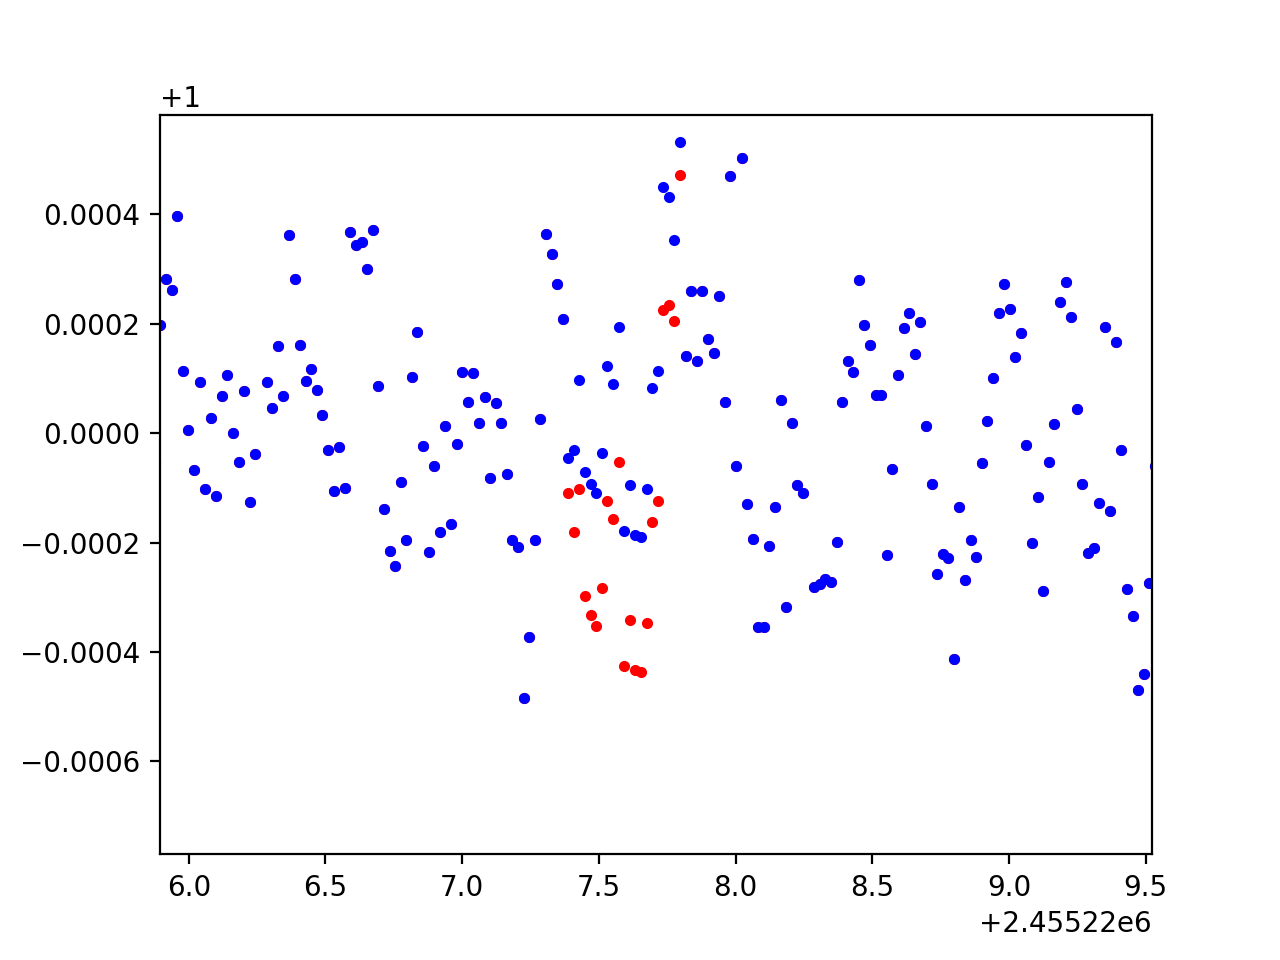

(0.995, 1.01)

In [14]:
p.figure()
p.plot(time_nt,flux_inj,'r.')

p.plot(time_nt,flux_nt,'b.')
#p.plot(time_nt_cut,flux_inj_cut,'m.',alpha=0.5)
p.ylim(0.995,1.01)

In [35]:
windows = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
minpoints = 3
blurscan = 2.0 #in days
#window lightcurve with duration - 
lcstat_nt_inj_cut = {}
blurlcstat_nt_inj_cut = {}
for win in windows:
    lcstat_nt_inj_cut[win], blurlcstat_nt_inj_cut[win] = funcs.running_mean_gaps(time_nt_cut,flux_inj_cut-1,win,minpoints,blurscan)
    


In [36]:
blurlcstat_nt_inj_cut_norm = funcs.normalise_stat(blurlcstat_nt_inj_cut,lcstat_nt_inj_cut,window=250)


<IPython.core.display.Javascript object>


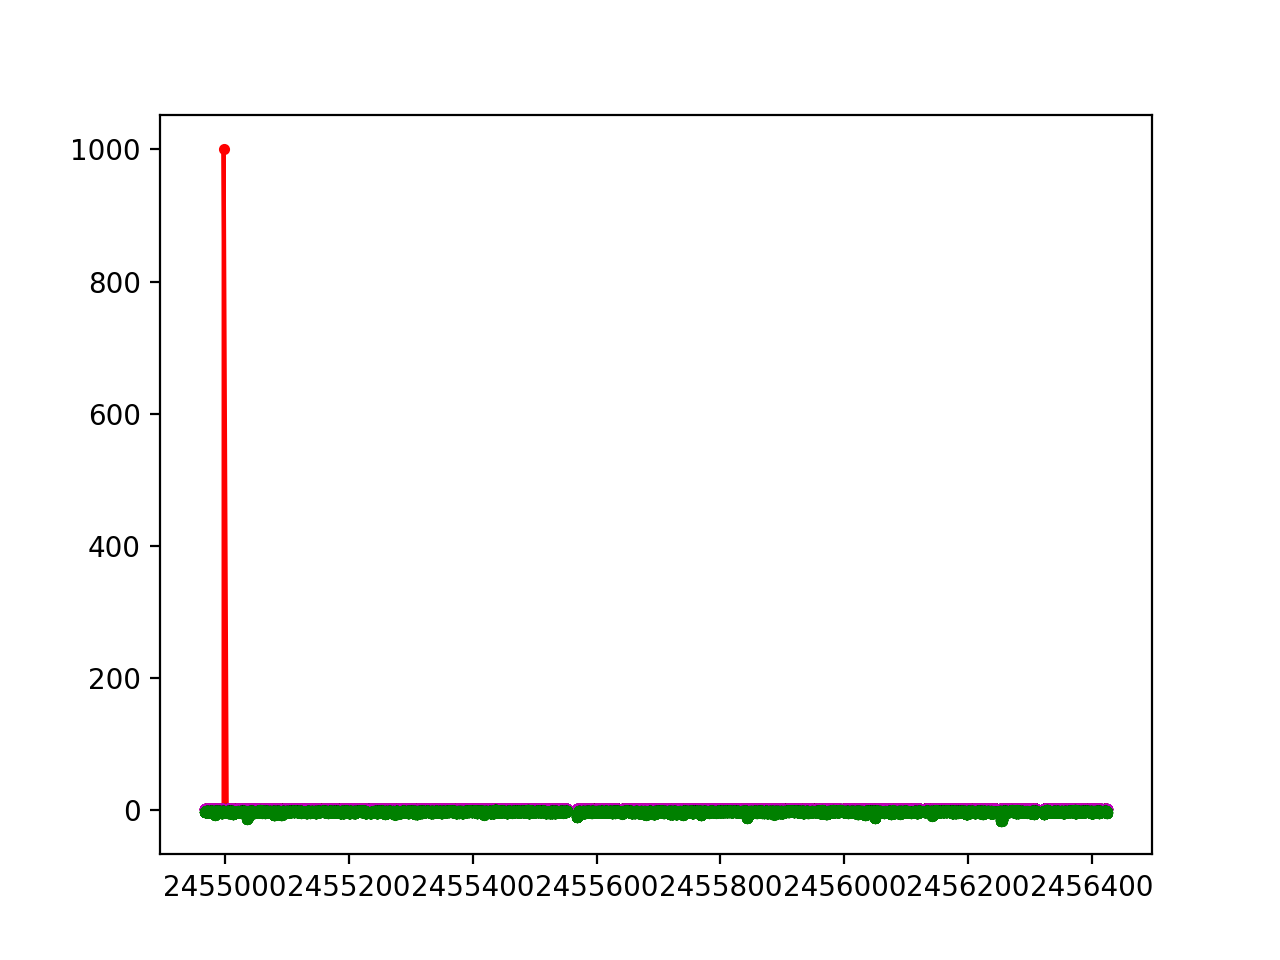

In [37]:
p.figure()
p.plot(time_nt,flux_inj,'b.')
p.plot(time_nt_cut,lcstat_nt_inj_cut[0.3]+1,'r.-')
p.plot(time_nt_cut,blurlcstat_nt_inj_cut[0.3]+1,'m.-')
p.plot(time_nt_cut,blurlcstat_nt_inj_cut_norm[0.3],'g.-')

#p.ylim(-10,1.05)

In [18]:
# Load nbody data (deserialize)
with open('K16_tts_all.pickle', 'rb') as handle:
    tts_all = pickle.load(handle)
with open('K16_tds_all.pickle', 'rb') as handle:
    tds_all = pickle.load(handle)


In [19]:
#define range over which to scan (needs to match that loaded. Could extract from dict keys
# but then lose precision
nbins = (1/200. - 1/500.) / (2.5e-6)
invppset = np.linspace(1/500.,1/200.,nbins)
ppset = 1./invppset[::-1] #uniform in frequency
fpset = np.linspace(0,2*np.pi,700)


/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [38]:
periodogram = funcs.make_periodogram_pertransit(tts_all,tds_all,time_nt_cut,ppset,fpset,windows,blurlcstat_nt_inj_cut_norm)

<IPython.core.display.Javascript object>


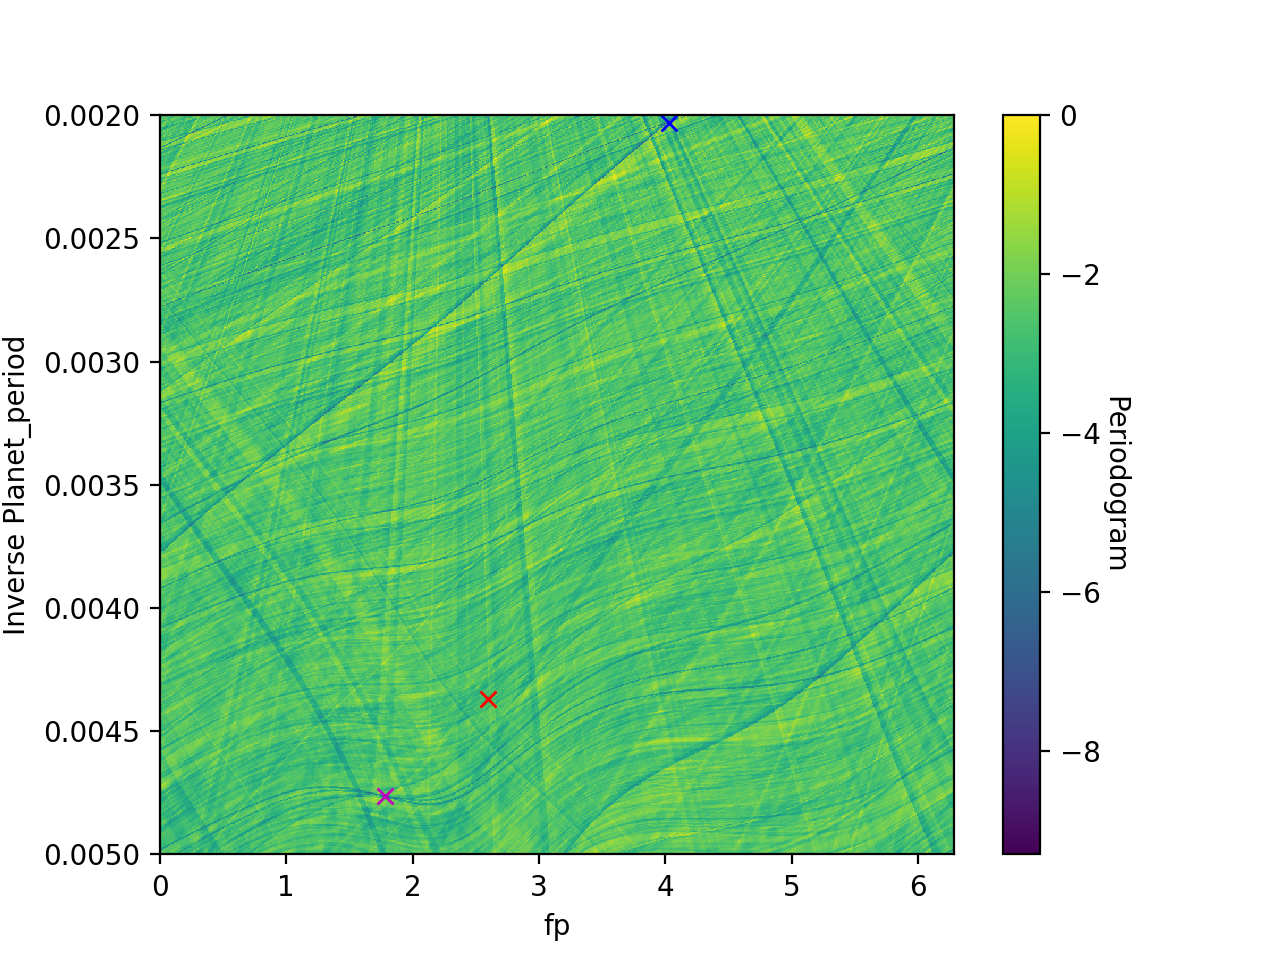

4.02699144151 492.604765818
-9.30766798067
-11.1680031517


In [39]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
p.plot(np.mod(cb.fp+cb.wp-np.deg2rad(318.0),2*np.pi),1./p_p,'mx')

minidx = np.unravel_index(np.argmin(periodogram),(len(ppset),len(fpset)))
p.plot(fpset[minidx[1]],1./ppset[minidx[0]],'bx')
print(fpset[minidx[1]],ppset[minidx[0]])
print(np.min(periodogram))
print((np.min(periodogram)-np.mean(periodogram))/np.std(periodogram))


In [43]:
periodogram_notpt = funcs.make_periodogram(tts_all,tds_all,time_nt_cut,ppset,fpset,windows,blurlcstat_nt_inj_cut_norm)

<IPython.core.display.Javascript object>


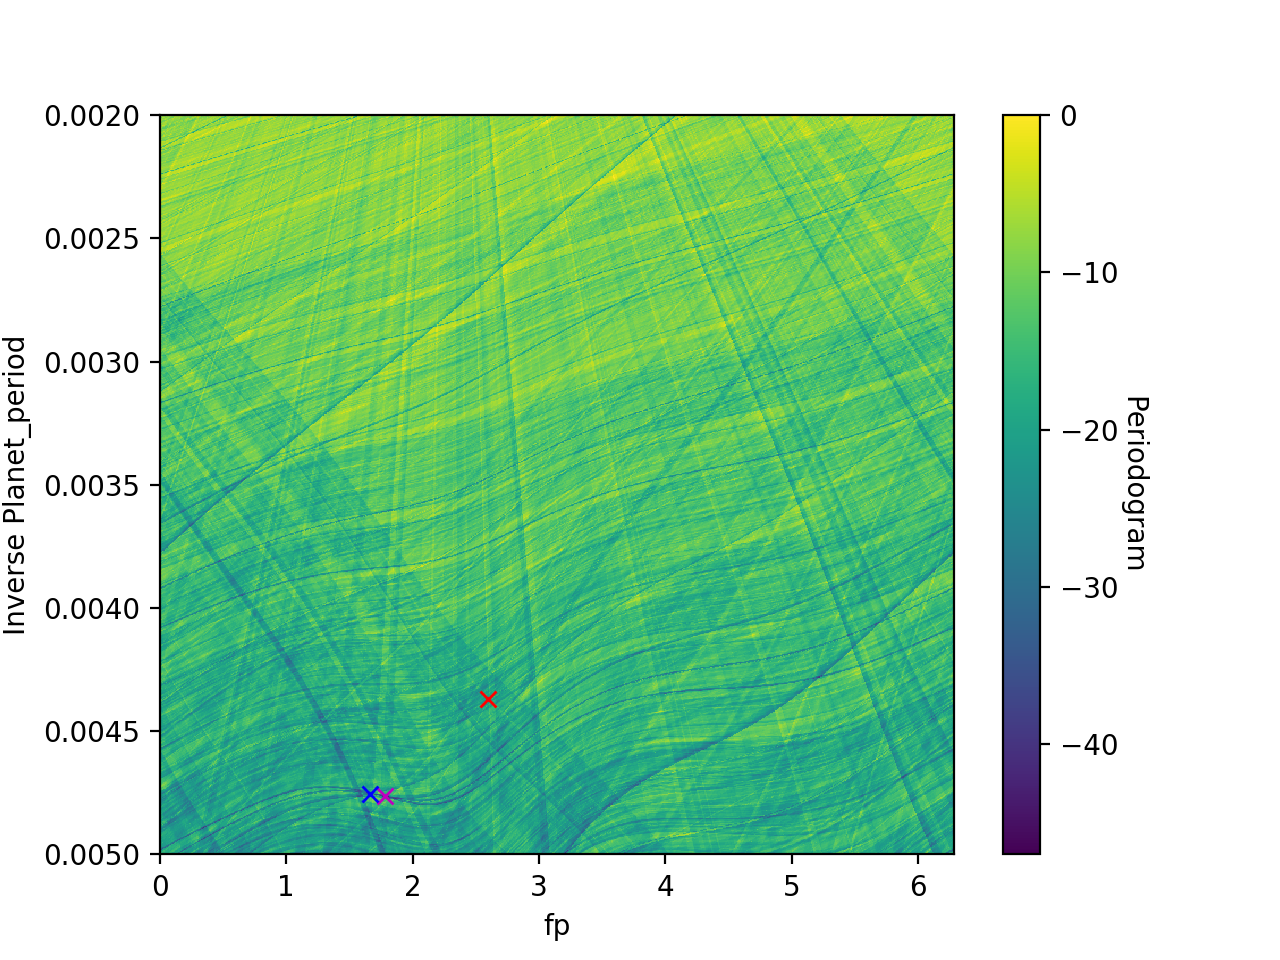

1.66293173366 210.313980004
-47.0077619421
-6.98168335607


In [44]:
p.figure()
palette = p.cm.viridis
p.imshow(periodogram_notpt,origin='lower',
         extent=[np.min(fpset),np.max(fpset),1./np.min(ppset),1./np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Periodogram', rotation=270, labelpad=10)
p.ylabel('Inverse Planet_period')
p.xlabel('fp')
p.plot(fp0,1./p_p0,'rx')
p.plot(np.mod(cb.fp+cb.wp-np.deg2rad(318.0),2*np.pi),1./p_p,'mx')

minidx_notpt = np.unravel_index(np.argmin(periodogram_notpt),(len(ppset),len(fpset)))
p.plot(fpset[minidx_notpt[1]],1./ppset[minidx_notpt[0]],'bx')
print(fpset[minidx_notpt[1]],ppset[minidx_notpt[0]])
print(np.min(periodogram_notpt))
print((np.min(periodogram_notpt)-np.mean(periodogram_notpt))/np.std(periodogram_notpt))


In [22]:
pp_inj = ppset[np.argmin(np.abs(ppset-p_p))]
fp_inj = fpset[np.argmin(np.abs(fpset-np.mod(cb.fp+cb.wp-np.deg2rad(318.0),2*np.pi)))]
print(tts_inj)
print(tts_all[str(pp_inj)[:6]][str(fp_inj)[:6]])

[ 2455022.36596273  2455227.59220727  2455432.85741198  2455638.16060286
  2455843.49950722  2456048.87185241  2456254.27536573]
[ 2455022.26273849  2455227.72768513  2455433.22671908  2455638.76406067
  2455844.34393023  2456049.9705481   2456255.64748533]


<IPython.core.display.Javascript object>


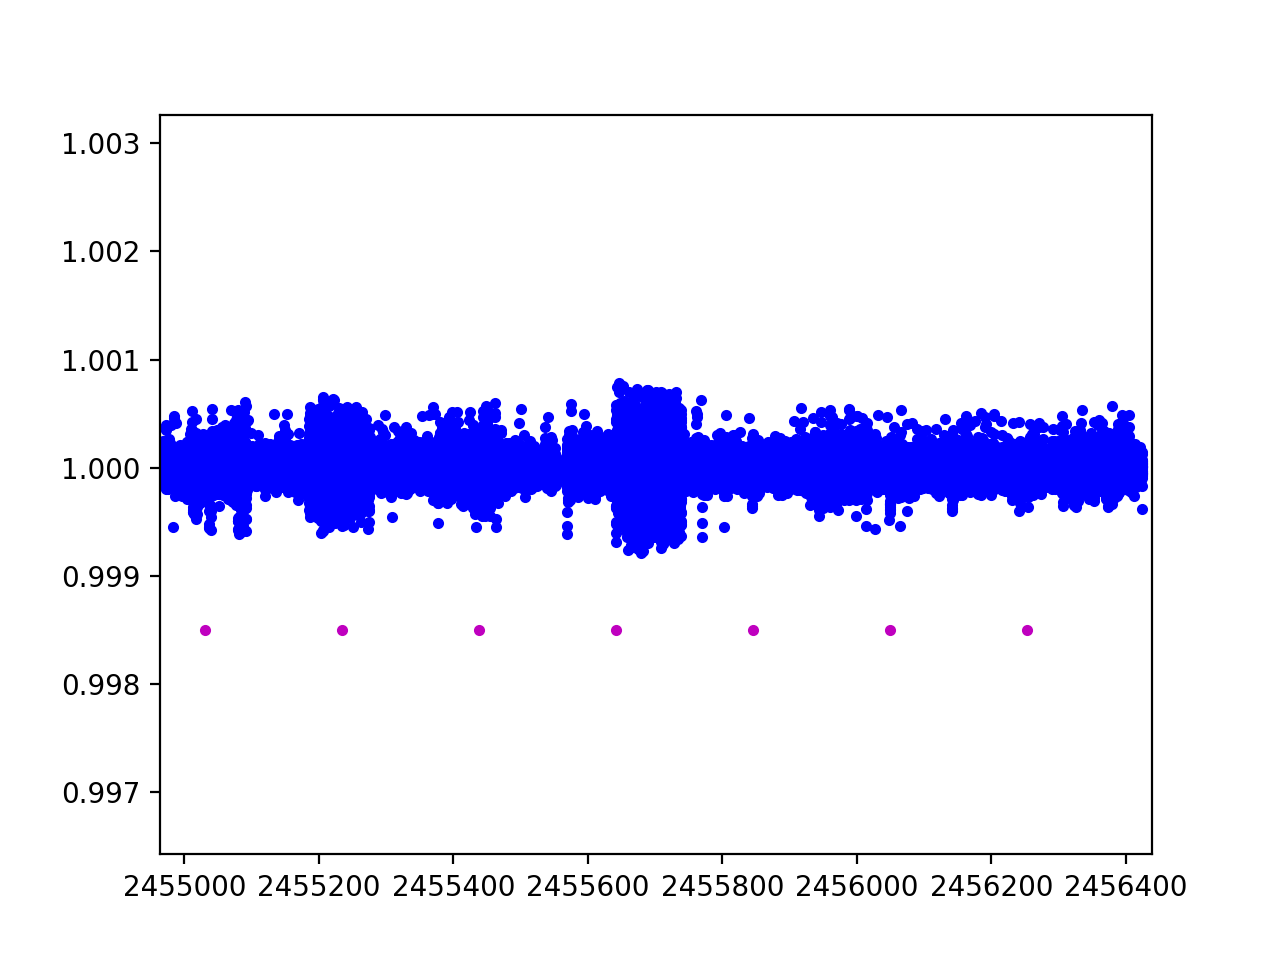

In [45]:
p.figure()
p.plot(time_nt_cut,flux_inj_cut,'b.')
#p.plot(time_nt_cut,lcstat_nt_inj_cut[0.3],'r.-')
p.plot(time_nt_cut,blurlcstat_nt_inj_cut_norm[0.3],'g.-')

pp = ppset[minidx_notpt[0]]
fp = fpset[minidx_notpt[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]

for transit,dur in zip(tts,tds):
    p.plot(transit,0.9985,'m.')
    #p.plot([transit-dur/2.,transit+dur/2.],[0.999,0.999])

#p.ylim(0.995,1.002)

<IPython.core.display.Javascript object>


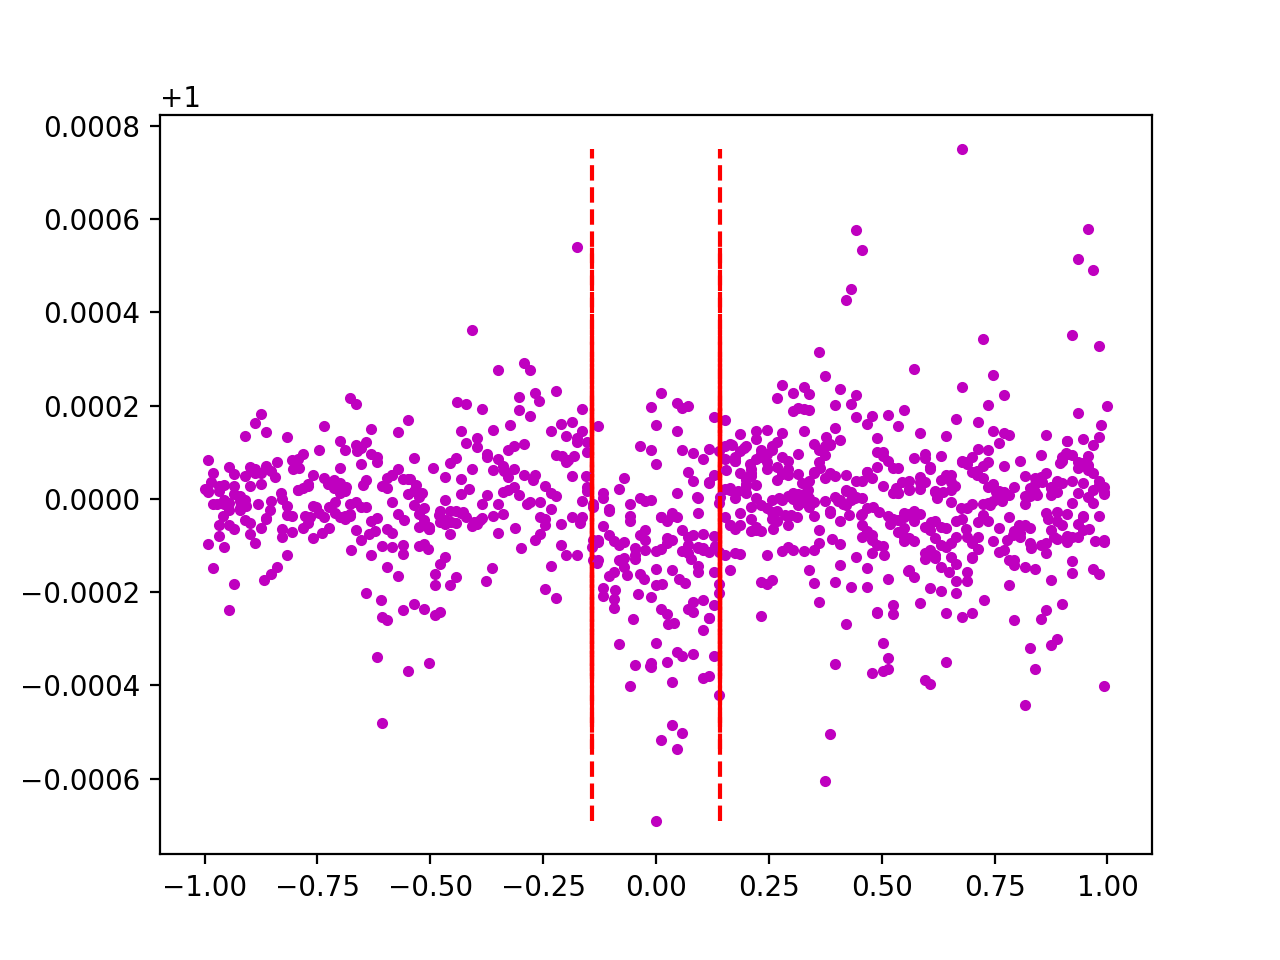

In [49]:
pp = ppset[minidx_notpt[0]]
fp = fpset[minidx_notpt[1]]

tts = tts_all[str(pp)[:6]][str(fp)[:6]]
tds = tds_all[str(pp)[:6]][str(fp)[:6]]
p.figure()

for transit,dur in zip(tts,tds):
    #what's the window and blur window?
    blurfactor = 2.0 #1.5 means a 3 duration window is scanned
    minpoints = 3
    
    time_window, flux_window, timescale = funcs.extract_transit_window(transit,dur,time_nt_cut,
                                                                       flux_inj_cut,windows,
                                                                       minpoints,blurfactor)             

    p.plot(timescale,flux_window,'m.')
    p.plot([-1/7.,-1/7.],[np.min(flux_window),np.max(flux_window)],'r--')
    p.plot([1/7.,1/7.],[np.min(flux_window),np.max(flux_window)],'r--')


<IPython.core.display.Javascript object>


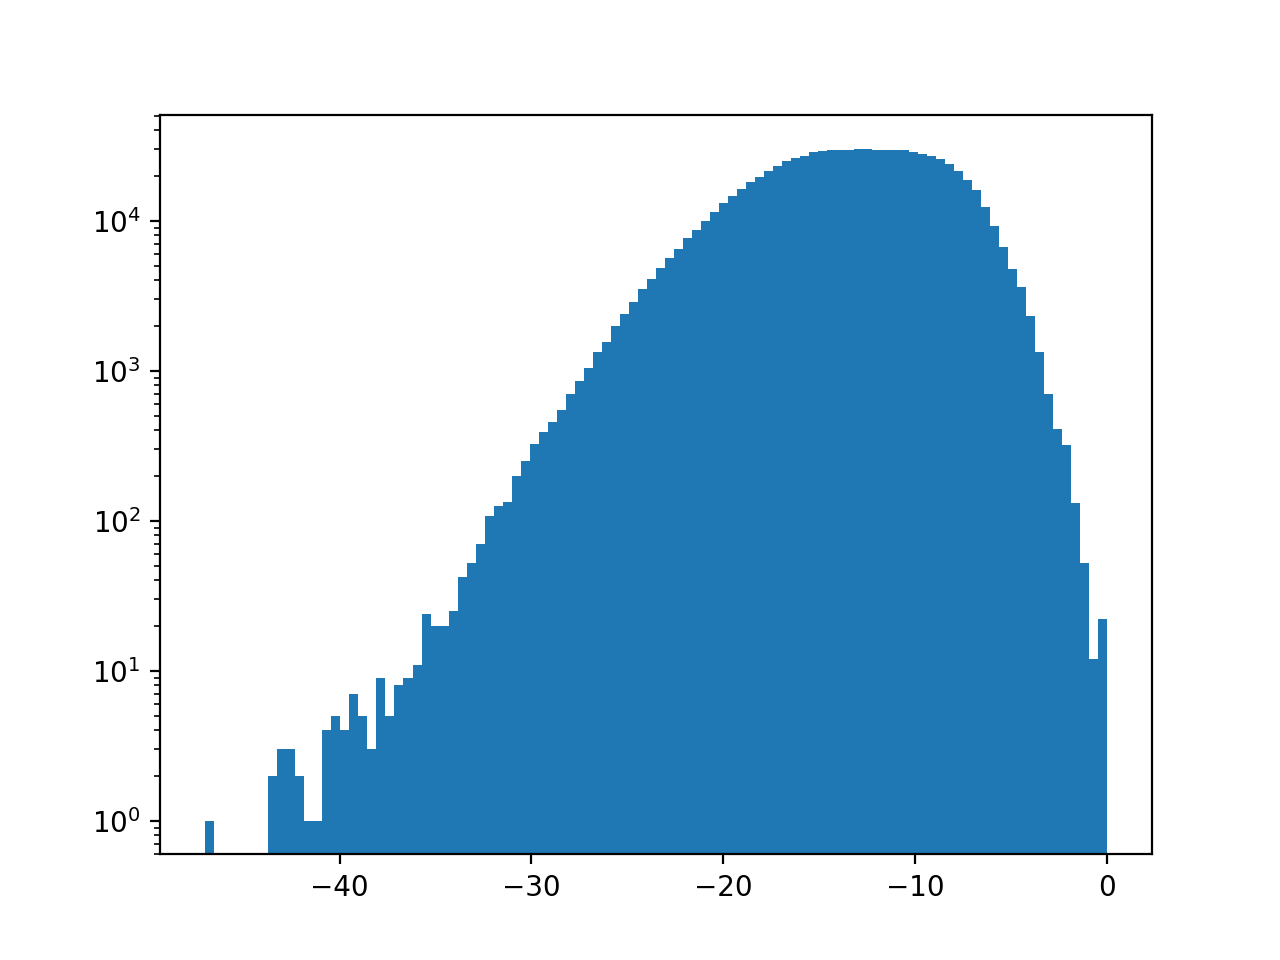

In [51]:
p.figure()
p.hist(periodogram_notpt.flatten(),bins=100)
p.yscale('log', nonposy='clip')